In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv('Data/ETFs/aadr.us.txt')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]


First few rows of the data:
             Close
Date              
2010-07-21  23.946
2010-07-22  24.487
2010-07-23  24.507
2010-07-26  24.595
2010-07-27  24.517

Missing values in each column:
 Close    0
dtype: int64

Statistical Summary:
             Close
count  1565.000000
mean     35.987517
std       6.933814
min      23.946000
25%      29.862000
50%      36.464000
75%      38.838000
max      58.430000


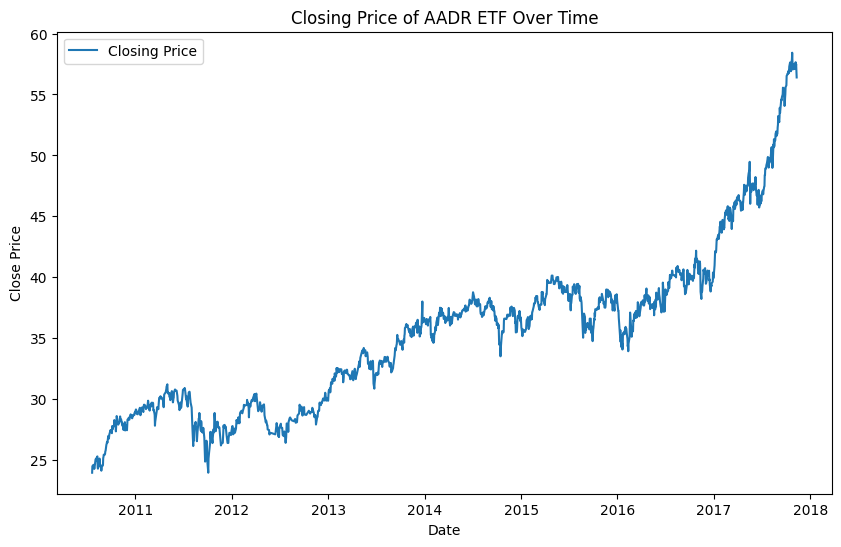

In [9]:
# Check the first few rows of the data
print("First few rows of the data:")
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values in each column:\n", missing_values)

# Basic statistical summary
print("\nStatistical Summary:")
print(data.describe())

# Plotting the closing prices
plt.figure(figsize=(10,6))
plt.plot(data['Close'], label='Closing Price')
plt.title('Closing Price of AADR ETF Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [30]:
sequence_length = 10
train_size = int(len(data) * 0.7)
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train[['Close']])


MinMaxScaler()

In [12]:
train_scaled = scaler.transform(train[['Close']])
test_scaled = scaler.transform(test[['Close']])

train_sequences, train_targets = create_sequences(train_scaled, sequence_length)
test_sequences, test_targets = create_sequences(test_scaled, sequence_length)


In [19]:
aapl_us = pd.read_csv("Data/Stocks/xyl.us.txt")
aapl_us['Date'] = pd.to_datetime(aapl_us['Date'])
aapl_us.set_index('Date', inplace=True)
aapl_us = aapl_us[['Close']].dropna()
aapl_us_scaled = scaler.transform(aapl_us)

xyl_sequences, xyl_targets = create_sequences(aapl_us_scaled, sequence_length)


In [32]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))


In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
history = model.fit(
    train_sequences,
    train_targets,
    epochs=20,
    batch_size=32,
    validation_data=(test_sequences, test_targets),
    shuffle=False
)


Epoch 1/20
34/34 [==============================] - 4s 38ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 2/20
34/34 [==============================] - 0s 12ms/step - loss: 0.0148 - val_loss: 0.0413
Epoch 3/20
34/34 [==============================] - 0s 11ms/step - loss: 0.0078 - val_loss: 0.0155
Epoch 4/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 5/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 6/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0146
Epoch 7/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0132
Epoch 8/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0160
Epoch 9/20
34/34 [==============================] - 0s 11ms/step - loss: 0.0074 - val_loss: 0.0189
Epoch 10/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0076 - val_loss: 0.0151
Epoch 11/

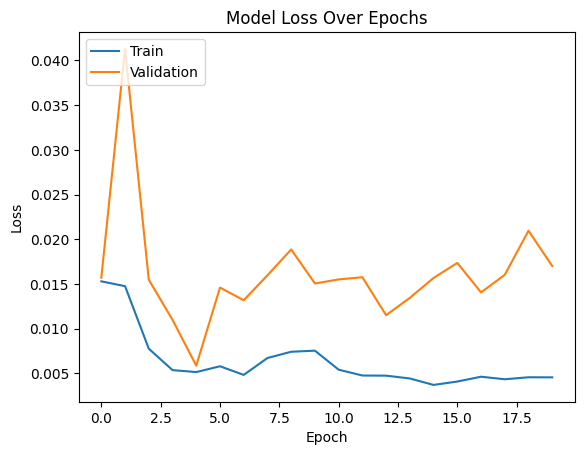

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
# Assuming your test_targets are in the shape of (samples, sequence_length, 1)
test_predictions = model.predict(test_sequences).reshape(-1, 1)
test_targets_reshaped = test_targets.reshape(-1, 1)

# Invert the scaling
test_predictions_inv = scaler.inverse_transform(test_predictions)
test_targets_inv = scaler.inverse_transform(test_targets_reshaped)


15/15 [==============================] - 0s 3ms/step


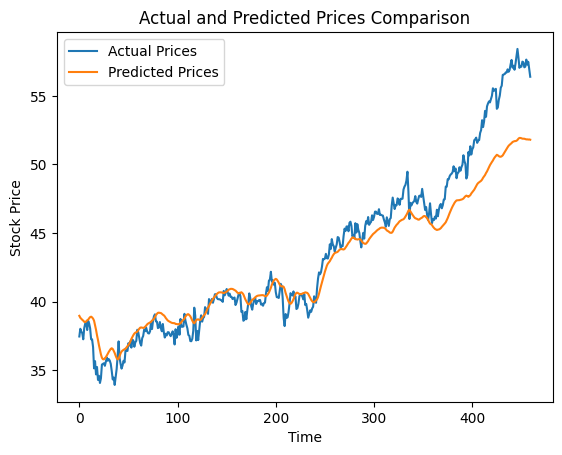

In [38]:
plt.plot(test_targets_inv.flatten(), label='Actual Prices')
plt.plot(test_predictions_inv.flatten(), label='Predicted Prices')
plt.title('Actual and Predicted Prices Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [40]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_targets_inv, test_predictions_inv)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R^2 Score
r2 = r2_score(test_targets_inv, test_predictions_inv)
print(f"Coefficient of Determination (R^2): {r2}")


Mean Absolute Error (MAE): 1.4758868094535493
Coefficient of Determination (R^2): 0.8828359013787319
